In [1]:
import numpy as np 
import math

class DBSCAN:
    
    UNLABELLED_DATA = -1
        
    metric = 'euclidean'    
    eps = 0.5
    min_pts = 5
    available_metrics = ['euclidean', 'manhattan']

    def __init__ (self, min_pts=min_pts, eps=eps, metric=metric):
        
        if eps <= 0:
            raise Exception('eps must be higher than 0')
        if min_pts <= 0:
            raise Exception('min_pts must be higher than 0')
        if metric not in available_metrics:
            raise Exception('No metric ' + str(metric))
            
        self.min_pts = min_pts
        self.eps = eps
        self.metric=metric
        
    def __euclidean_distance(self, point_a, point_b):
        dist = 0
        for a, b in zip(point_a, point_b):
            dist += (a - b) * (a - b)
        return np.sqrt(dist)

    def __manhattan_distance(self, point_a, point_b):
        dist = 0
        for a, b in zip(point_a, point_b):
            dist += abs(a - b)
        return dist
    
    def __distance(self, point_a, point_b, metric=metric):
        # 
        if len(point_a) == len(point_b):
            if metric == 'euclidean':
                return self.__euclidean_distance(point_a, point_b)
            if metric == 'manhattan':
                return self.__manhattan_distance(point_a, point_b)
        else:
            raise Exception("feature length doesn't same")
    
    def fit_predict(self, data):
        size_data = len(data)
        
        # generate all neighbours 
        neighbours = []
        for i in range(size_data):
            neighbour_i = []
            for j in range(size_data):
                if self.__distance(data[i], data[j], self.metric) <= self.eps:
                    neighbour_i.append(j)
            neighbours.append(neighbour_i)
        
        # initialize label
        result = np.full((size_data), self.UNLABELLED_DATA)
        
        # giving label to data
        curr_label = 0
        for i in range(size_data):
            # if neighbours > min_pts (core points) then give label 
            if len(neighbours[i]) >= self.min_pts and result[i] == self.UNLABELLED_DATA: 
                label = curr_label
                # giving label to all neighbours
                neighbours_i = [i]
                while len(neighbours_i) > 0:
                    neigh_i = neighbours_i.pop()
                    # if not yet labelled then give label to data and the neighbours
                    if result[neigh_i] == self.UNLABELLED_DATA:
                        result[neigh_i] = label
                        # if neigh_i is core point, then give label to the neighbour
                        if len(neighbours[neigh_i]) >= self.min_pts:
                            neighbours_i += neighbours[neigh_i]
                curr_label += 1
                
        return result
        

In [6]:
import numpy as np
import math

class tes_AgglomerativeClustering:
    
    n_clusters = 2
    linkage = 'complete'
    metrics = 'euclidean'
    
    available_metrics = ['euclidean', 'manhattan', 'cosine']
    available_linkage = ['complete', 'single', 'group_average', 'average']
    
    def __init__(self, n_clusters=n_clusters, linkage=linkage, metrics=metrics):
        
        if n_clusters <= 0:
            raise Exception('n_clusters must be higher than 0')
        if metrics not in self.available_metrics:
            raise Exception('No metric ' + str(metrics))
        if linkage not in self.available_linkage:
            raise Exception('No linkage ' + str(linkage))
        self.metrics = metrics
        self.n_clusters = n_clusters
        self.linkage = linkage
        
    def __euclidean_distance(self, data1, data2):
        sum = 0
        if (len(data1) == len(data2)):
            for x1, x2 in zip(data1, data2):
                sum += (x1 - x2)**2
            dist = math.sqrt(sum)
            return dist
        else:
            raise Exception('Length doesn\'t match')

    def __manhattan_distance(self, data1, data2):
        sum = 0
        if (len(data1) == len(data2)):
            for x1, x2 in zip(data1, data2):
                sum += abs(x1 - x2)
            return sum
        else:
            raise Exception('Length doesn\'t match')
            
    def __cosine_distance(self, data1, data2):
        return np.dot(data1, data2) / (np.linalg.norm(data1) * np.linalg.norm(data2))

    def __get_distance(self, data1, data2, metrics):
        if (metrics == 'euclidean'):
            dist = self.__euclidean_distance(data1, data2)
        elif (metrics == 'manhattan'):
            dist = self.__manhattan_distance(data1, data2)
        elif (metrics == 'cosine'):
            dist = self.__cosine_distance(data1, data2)
        else:
            raise Exception('Metrics not defined')
        return dist
    
    def __complete_linkage(self, cluster1, cluster2, dist_matrix):
        max_dist = 0
        for v1 in cluster1:
            for v2 in cluster2:
                if (max_dist < dist_matrix[v1][v2]):
                    max_dist = dist_matrix[v1][v2]
        return max_dist

    def __single_linkage(self, cluster1, cluster2, dist_matrix):
        min_dist = None
        for v1 in cluster1:
            for v2 in cluster2:
                if (min_dist is None) or (min_dist > dist_matrix[v1][v2]):
                    min_dist = dist_matrix[v1][v2]
        return min_dist

    def __average_linkage(self, cluster1, cluster2, dist_matrix):
        sum_dist = 0
        count_dist = 0
        for v1 in cluster1:
            for v2 in cluster2:
                sum_dist += dist_matrix[v1][v2]
                count_dist += 1
        return float(sum_dist)/float(count_dist)

    def __group_average_linkage(self, cluster1, cluster2, data, distance):
        data1 = [data[i] for i in cluster1]
        data2 = [data[i] for i in cluster2]

        avg1 = np.mean(data1, axis = 0)
        avg2 = np.mean(data2, axis = 0)

        return self.__get_distance(avg1, avg2, distance)
    
    def __calculate_distance_matrix(self, data, metrics):
        dist_matrix = []
        for idx1, data1 in enumerate(data):
            curr_dist_matrix = []
            for idx2, data2 in enumerate(data):
                if (idx1 > idx2):
                    curr_dist_matrix.append(dist_matrix[idx2][idx1])
                else:
                    dist = self.__get_distance(data1, data2, metrics)
                    curr_dist_matrix.append(dist)
            dist_matrix.append(curr_dist_matrix)
        return dist_matrix
        
    def fit_predict(self, data):
        dist_matrix = self.__calculate_distance_matrix(data, self.metrics)
        clusters = [[i] for i, c in enumerate(data)]

        while(len(clusters) > self.n_clusters):
            min_dist = None
            merge_pair = (0, 0)
            for idx1, c1 in enumerate(clusters):
                for idx2, c2 in enumerate(clusters[(idx1 + 1) :]):
                    if (self.linkage == 'single'):
                        dist = self.__single_linkage(c1, c2, dist_matrix)
                    elif (self.linkage == 'complete'):
                        dist = self.__complete_linkage(c1, c2, dist_matrix)
                    elif (self.linkage == 'average'):
                        dist = self.__average_linkage(c1, c2, dist_matrix)
                    elif (self.linkage == 'average_group'):
                        dist = self.__group_average_linkage(c1, c2, data, self.metrics)
                    else:
                        raise Exception('Linkage not defined')
                    if (min_dist == None) or (dist < min_dist):
                        min_dist = dist
                        merge_pair = (idx1, idx1 + 1 + idx2)

            result_cluster = []
            for idx, c in enumerate(clusters):
                if idx not in merge_pair:
                    result_cluster.append(c)

            result_cluster.append(clusters[merge_pair[0]] + clusters[merge_pair[1]])

            clusters = result_cluster

#         print(clusters)
#         result_per_item = np.zeros(len(data))
        result_per_item = np.full(len(data), 0)
        for idx, clust in enumerate(clusters):
            result_per_item[clust] = idx

        return result_per_item

In [20]:
from sklearn import datasets
data = datasets.load_iris().data
data_used = data

import time

aglo = tes_AgglomerativeClustering(n_clusters=4, linkage='average', metrics='manhattan')
start_time = time.time()
pred_a = aglo.fit_predict(data_used)
print("--- %s seconds ---" % (time.time() - start_time))
pred_a

--- 2.5115652084350586 seconds ---


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1])

In [21]:
from sklearn.cluster import AgglomerativeClustering

cls = AgglomerativeClustering(n_clusters= 4, linkage='average', affinity='manhattan')
start_time = time.time()
pred_sk = cls.fit_predict(data_used)
print("--- %s seconds ---" % (time.time() - start_time))
pred_sk

--- 0.007964611053466797 seconds ---


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2])

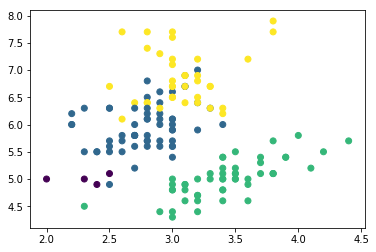

In [22]:
import matplotlib.pyplot as plt

plt.scatter(data[:,1], data[:,0], c=pred_a)
plt.show()

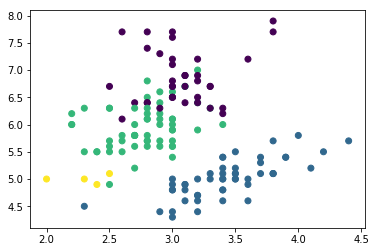

In [23]:
plt.scatter(data[:,1], data[:,0], c=pred_sk)
plt.show()